In [1]:
import numpy as np
from matplotlib import pyplot as plt
from dsapol import dsapol
from scipy.signal import correlate
from scipy.signal import savgol_filter as sf
from scipy.signal import convolve
from scipy.signal import fftconvolve
from scipy.ndimage import convolve1d
from scipy.signal import peak_widths
from scipy.stats import chi
from scipy.stats import norm
import matplotlib.ticker as ticker

import panel as pn
pn.extension()
#from numpy.ma import masked_array as ma
import numpy.ma as ma
from scipy.stats import kstest
from scipy.optimize import curve_fit
import time
#import numpy.ma as ma 
%load_ext autoreload
%autoreload 2 

from scipy.signal import find_peaks
from scipy.signal import peak_widths
import copy
import numpy as np
import os
import param

from sigpyproc import FilReader
from sigpyproc.Filterbank import FilterbankBlock
from sigpyproc.Header import Header
from matplotlib import pyplot as plt
import pylab
import pickle
import json
from scipy.interpolate import interp1d
from scipy.stats import chi2
from scipy.stats import chi
from scipy.signal import savgol_filter as sf
from scipy.signal import convolve
from scipy.ndimage import convolve1d
from RMtools_1D.do_RMsynth_1D import run_rmsynth
from RMtools_1D.do_RMclean_1D import run_rmclean
from RMtools_1D.do_QUfit_1D_mnest import run_qufit

plt.rcParams.update({
                    'font.size': 16,
                    'font.family': 'serif',
                    'axes.labelsize': 16,
                    'axes.titlesize': 16,
                    'xtick.labelsize': 12,
                    'ytick.labelsize': 12,
                    'xtick.direction': 'in',
                    'ytick.direction': 'in',
                    'xtick.top': True,
                    'ytick.right': True,
                    'lines.linewidth': 1,
                    'lines.markersize': 5,
                    'legend.fontsize': 14,
                    'legend.borderaxespad': 0,
                    'legend.frameon': False,
                    'legend.loc': 'lower right'})


from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u


def gauss_scint(x,bw,amp,off):
    return off + amp*np.exp(-np.log(2)*((x/bw)**2))


def lorentz_scint(x,bw,amp,off):
    return off + amp*(bw/(x**2 + (0.5*bw**2)))

fsize=30
fsize2=20
plt.rcParams.update({
                    'font.size': fsize,
                    'font.family': 'sans-serif',
                    'axes.labelsize': fsize,
                    'axes.titlesize': fsize,
                    'xtick.labelsize': fsize,
                    'ytick.labelsize': fsize,
                    'xtick.direction': 'in',
                    'ytick.direction': 'in',
                    'xtick.top': True,
                    'ytick.right': True,
                    'lines.linewidth': 1,
                    'lines.markersize': 5,
                    'legend.fontsize': fsize2,
                    'legend.borderaxespad': 0,
                    'legend.frameon': False,
                    'legend.loc': 'lower right'})

In [2]:
#import functions from polarization modules
from pol_panel_funcs import pol_plot
from pol_panel_funcs import pol_panel
from pol_panel_funcs import RM_plot
from pol_panel_funcs import RM_panel
from pol_panel_callbacks import callback
from pol_panel_callbacks import callback_cal
from pol_panel_callbacks import callback_link
from pol_panel_callbacks import callback_linkback
from pol_panel_callbacks import callback_RMcal

#import functions from usage module
import usage_panel_funcs

#import functions from dedisp module
from dedisp_panel_funcs import dedisp_plot
from dedisp_panel_funcs import dedisp_panel


In [39]:
x=["2023T01:00:00","2023T02:00:00"]
x.sort()
x = x[::-1]
x

['2023T02:00:00', '2023T01:00:00']

In [46]:
#build panel functions

def build_dedisp_tab():
    
    
    # make dropdown box to choose FRB file
    x=os.listdir("/media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us") 
    FRB_list = []
    for i in range(len(x)):
        if len(x[i]) >= 10 and x[i][10] == "_":
            FRB_list.append(x[i])

    menu_calplots = pn.widgets.MenuButton(name="Select FRB to Load",
                                          items=FRB_list,
                                         width=200)
    
    # make dropdown box to choose beamformer weights
    x=os.listdir("/dataz/dsa110/operations/beamformer_weights/applied")
    bf_list = []
    for i in range(len(x)): #beamformer_weights_sb07_2022-10-21T00:41:56.dat
        if "sb01" in x[i]:
            bf_list.append(x[i][24:43])
    bf_list.sort()
    bf_list = bf_list[::-1]
    
    menu_bf = pn.widgets.MenuButton(name="Select Beamformer Weights",
                                      items=bf_list,
                                     width=200)
    
    load_button = pn.widgets.Button(name='Load FRB', width=100, button_type='primary')
    DM_input = pn.widgets.FloatInput(name='Input DM (pc/cc)', value=0, step=1e-2, start=0, end=10000)
    ibeam_input = pn.widgets.IntSlider(name='ibeam', start=0, end=250, step=1, value=0)
    mjd_input = pn.widgets.TextInput(name='mjd',placeholder='Enter mjd here')
    

    #create polarization pane and links for initialization
    pane_test = pn.pane.Markdown('# DSA-110 Dedispersion Tuning Dashboard')
    pan1 = dedisp_panel()
    
    menu_calplots.link(pan1, clicked='frb_name')
    menu_bf.link(pan1,clicked='caldate')
    load_button.link(pan1,callbacks={'clicks': callback})#pan1, clicks='frb_submitted')
    DM_input.link(pan1,value='DM')
    ibeam_input.link(pan1,value='ibeam')
    mjd_input.link(pan1,value='mjd')
    
    
    return pn.Column(pane_test,pn.Row(menu_calplots,menu_bf,load_button,ibeam_input,mjd_input),pn.Row(DM_input),pn.Row(pan1.param,pan1.view))


def build_pol_tab():
    
    
    
    # make dropdown box to choose FRB file
    x=os.listdir("/media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us") 
    FRB_list = []
    for i in range(len(x)):
        if len(x[i]) >= 10 and x[i][10] == "_":
            FRB_list.append(x[i])

    menu_calplots = pn.widgets.MenuButton(name="Select FRB to Load",
                                          items=FRB_list,
                                         width=200)
    
    load_button = pn.widgets.Button(name='Load FRB', width=100, button_type='primary')
    
    # make dropdown box to choose calibration file
    y = os.listdir("/media/ubuntu/ssd/sherman/code")
    CAL_list = []
    
    for i in range(len(y)):
        if ("POLCAL_PARAMETERS" in y[i]) and ("csv" in y[i]):
            CAL_list.append(y[i])
    calmenu_calplots = pn.widgets.MenuButton(name="Select Calibration File to Load",
                                      items=CAL_list,
                                     width=200)
    
    #calibration button and beam, RA, dec input for PA calibration
    cal_button = pn.widgets.Button(name='Calibrate', width=100, button_type='primary')
    ibeam_input = pn.widgets.IntSlider(name='ibeam', start=0, end=250, step=1, value=0)
    RA_input = pn.widgets.FloatInput(name='RA (degrees)', value=0, step=1e-2, start=0, end=360)
    DEC_input = pn.widgets.FloatInput(name='DEC (degrees)', value=0, step=1e-2, start=-90, end=90)
    

    #create polarization pane and links for initialization
    pane_test = pn.pane.Markdown('# DSA-110 Polarization Dashboard')
    pan1 = pol_panel()
    
    menu_calplots.link(pan1, clicked='frb_name')
    load_button.link(pan1,callbacks={'clicks': callback})#pan1, clicks='frb_submitted')
    
    calmenu_calplots.link(pan1,clicked='cal_name')
    cal_button.link(pan1,callbacks={'clicks': callback_cal})#pan1, clicks='frb_submitted')
    ibeam_input.link(pan1,value='ibeam')
    RA_input.link(pan1,value='RA')
    DEC_input.link(pan1,value='DEC')
    
    #create RM pane and links for passing data
    pan2 = RM_panel()
  
    link_button = pn.widgets.Button(name='Proceed to RM Synthesis',width=200,button_type='primary')
    #link_button.link(pan2,callbacks={'clicks': callback_link})#pan1, clicks='frb_submitted')
    link_button.link(pan2,callbacks={'clicks': lambda target,event: callback_link(target,event,pan1)})
    
    linkback_button = pn.widgets.Button(name='Return to Pol Analysis',width=200,button_type='primary')
    #linkback_button.link(pan1,callbacks={'clicks':callback_linkback})
    linkback_button.link(pan1,callbacks={'clicks':lambda target,event: callback_linkback(target,event,pan2)})
    
 
    RMcal_button = pn.widgets.Button(name='RM Calibrate',width=200,button_type='primary')
    #RMcal_button.link(pan1,callbacks={'clicks':callback_RMcal})
    RMcal_button.link(pan1,callbacks={'clicks':lambda target,event: callback_RMcal(target,event,pan2)})
    
    
    return pn.Column(pane_test,pn.Row(menu_calplots,load_button,calmenu_calplots,ibeam_input,RA_input,DEC_input,cal_button,link_button,linkback_button,RMcal_button),pn.Row(pan1.param,pan1.view,pan2.param,pan2.view))


#ADD JAKOB'S CODE HERE FOR BURSTFIT TAB
def burstfit_tab():
    pass
    
    
#usage tab

def build_usage_tab():
    
    #dedisp tab
    dedisp_usage = usage_panel_funcs.dedisp_usage_str
    
    #pol tab
    pol_usage = usage_panel_funcs.pol_usage_str
    
    
    #burstfit tab
    burstfit_usage = usage_panel_funcs.burstfit_usage_str
    
    
    width=1500
    
    title = """
            # **Burst Analysis Dashboard Usage**
                                      
            ## This page contains instructions and examples for using the Burst Analysis Dashboard
            """
    
    return pn.Column(pn.pane.Markdown(title,width=width),
                     pn.pane.Markdown(dedisp_usage,width=width),
                    pn.pane.Markdown(pol_usage,width=width),
                    pn.pane.Markdown(burstfit_usage,width=width))

In [47]:
pol_pane = pn.param.ParamFunction(build_pol_tab,lazy=True)


In [48]:
usage_pane = pn.param.ParamFunction(build_usage_tab,lazy=True)

In [49]:
dedisp_pane = pn.param.ParamFunction(build_dedisp_tab,lazy=True)

In [50]:
dashboard = pn.Column(pn.Row(pn.layout.tabs.Tabs(('Usage', usage_pane),
                                                 ('Dedispersion', dedisp_pane),
                                                 ('Polarization', pol_pane),
                                                 #('Burstfit',burstfit_tab),
                                                dynamic=True, active=1),
                             margin=(10, 10, 10, 10), background='#f0f0f0'))

/media/ubuntu/ssd/sherman/code/dedisp_panel_funcs.py:329: RuntimeWarning: divide by zero encountered in double_scalars
  self.ddmdelay = -1 * self.ddm * k_dm * (1/(self.freq_axis[-1] ** 2) - 1/(self.freq_axis[0] ** 2)) #ms
/media/ubuntu/ssd/sherman/code/dedisp_panel_funcs.py:329: RuntimeWarning: invalid value encountered in double_scalars
  self.ddmdelay = -1 * self.ddm * k_dm * (1/(self.freq_axis[-1] ** 2) - 1/(self.freq_axis[0] ** 2)) #ms
/media/ubuntu/ssd/sherman/code/dedisp_panel_funcs.py:351: RuntimeWarning: invalid value encountered in true_divide
  self.I_t = (np.mean(self.I,axis=0) - np.mean(np.mean(self.I[:,:int(12000//self.n_t)],axis=0)))/np.std(np.mean(self.I[:,:int(12000//self.n_t)],axis=0))
/media/ubuntu/ssd/sherman/code/dedisp_panel_funcs.py:155: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  c=ax1.imshow(I[:,timestart:timestop],aspect="auto",vmax=np.percentile(I,perc))
/media/ubuntu/ssd/sherm

Reading stokes param...0Reading Filterbank File: /media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/230325aaag_freya/230325aaag_dev_0.fil 
Reading Filterbank File: /media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us/230325aaag_freya/230325aaag_dev_0.fil 
Binning by 1 in time 
Binning by 64 in frequency 
Bad Channels: []

Column
    [0] Row(background='#f0f0f0', margin=(10, 10, 10, 10))
        [0] Tabs(active=1, dynamic=True)
            [0] ParamFunction(function, lazy=True)
            [1] ParamFunction(function, lazy=True)
            [2] ParamFunction(function, lazy=True)
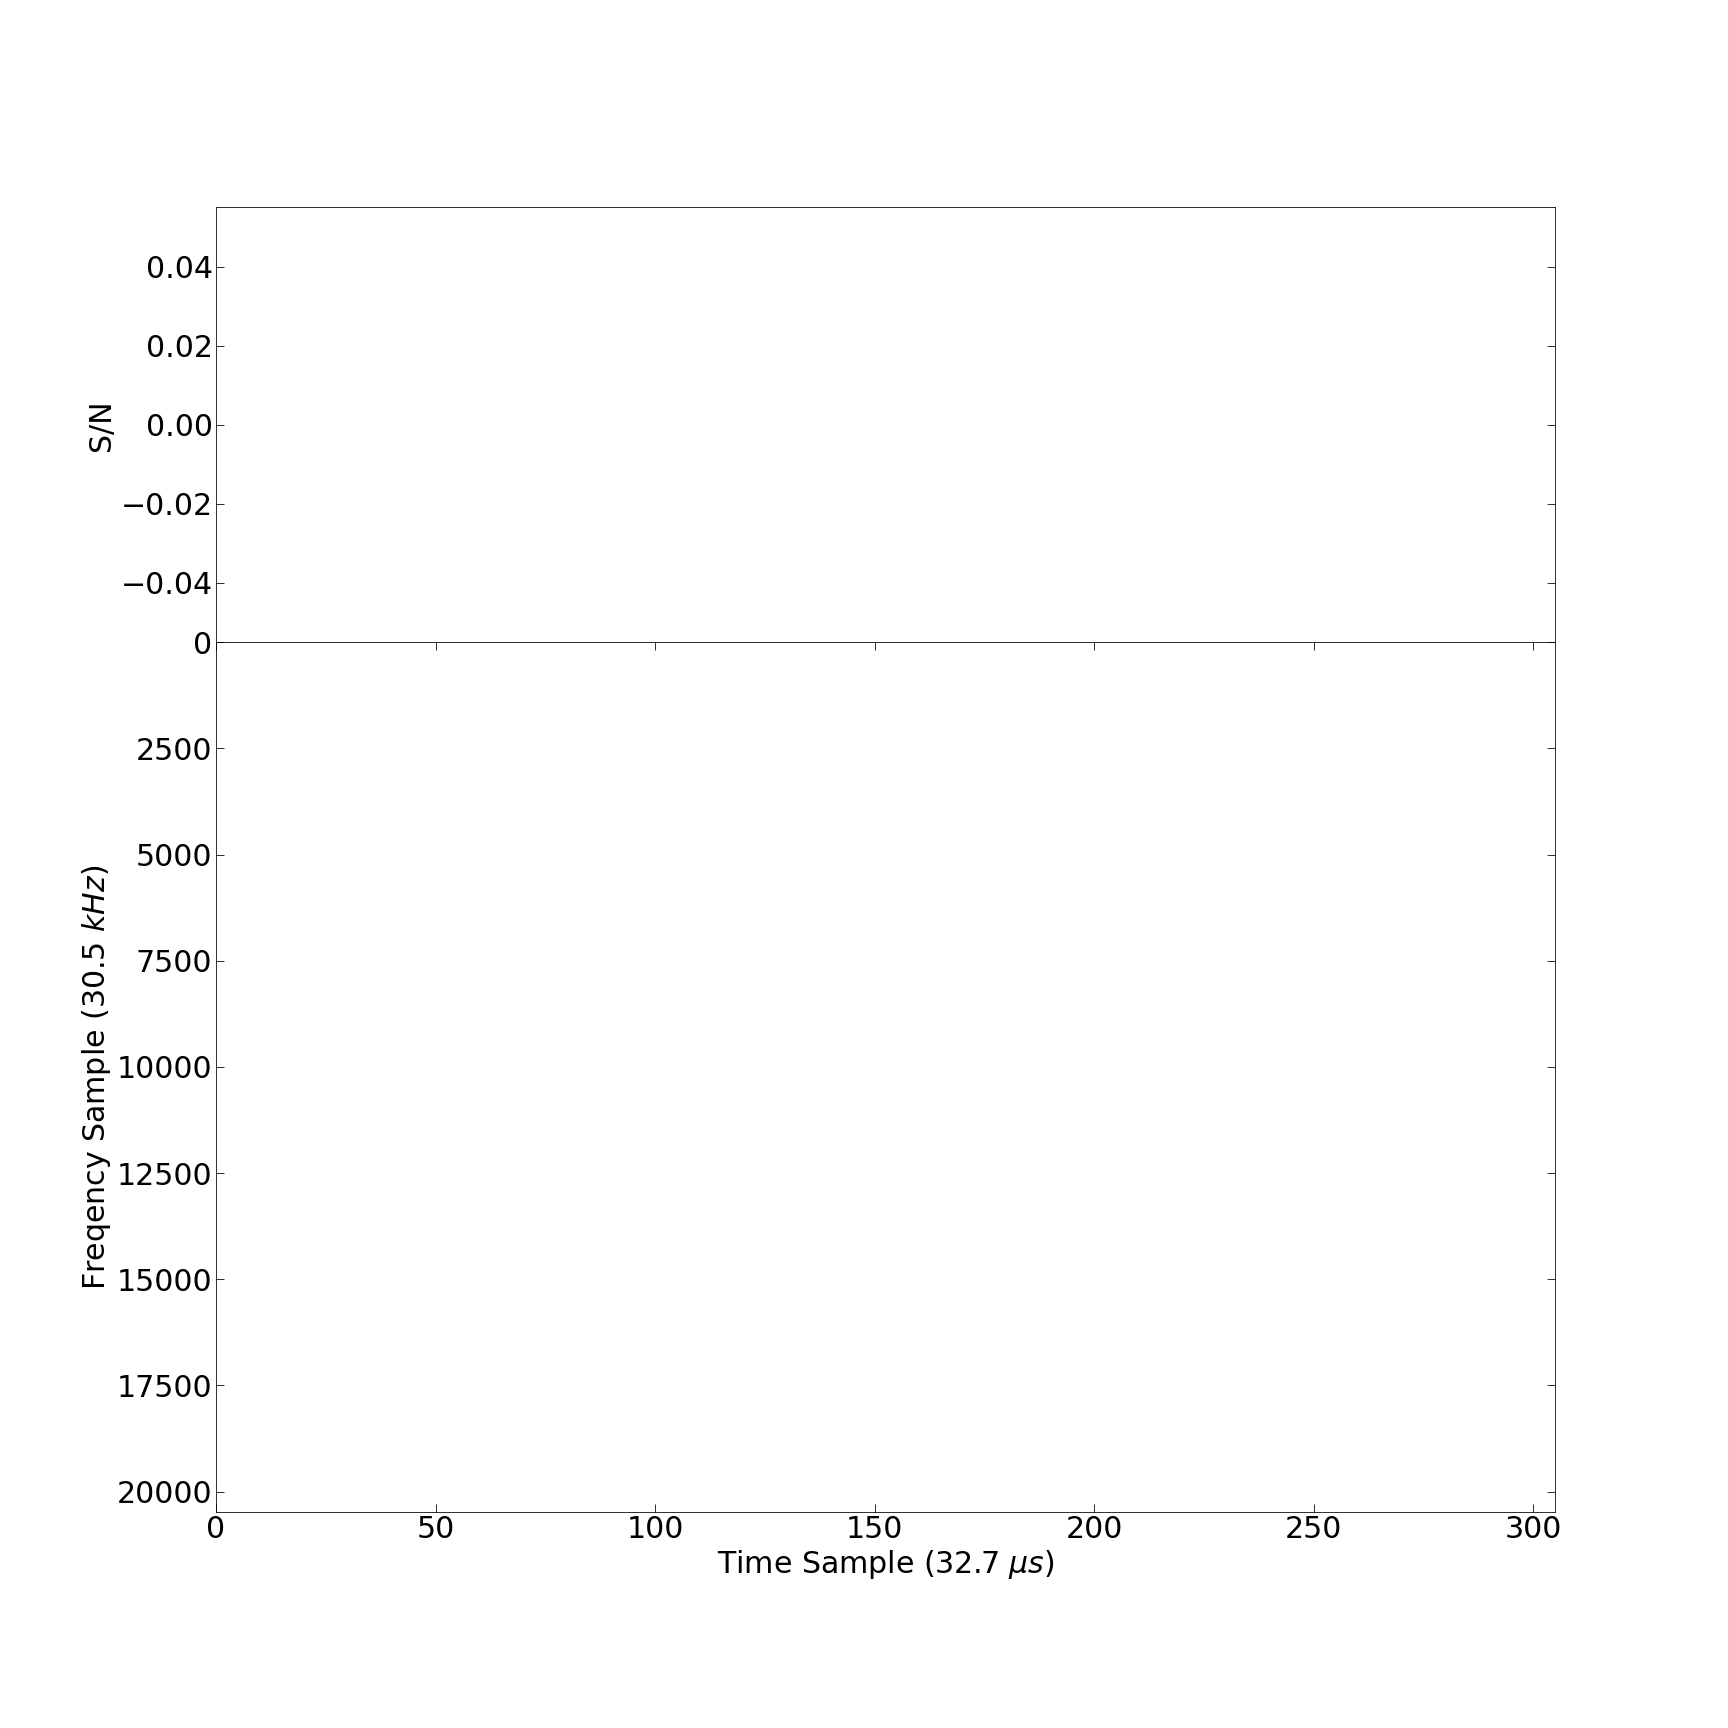

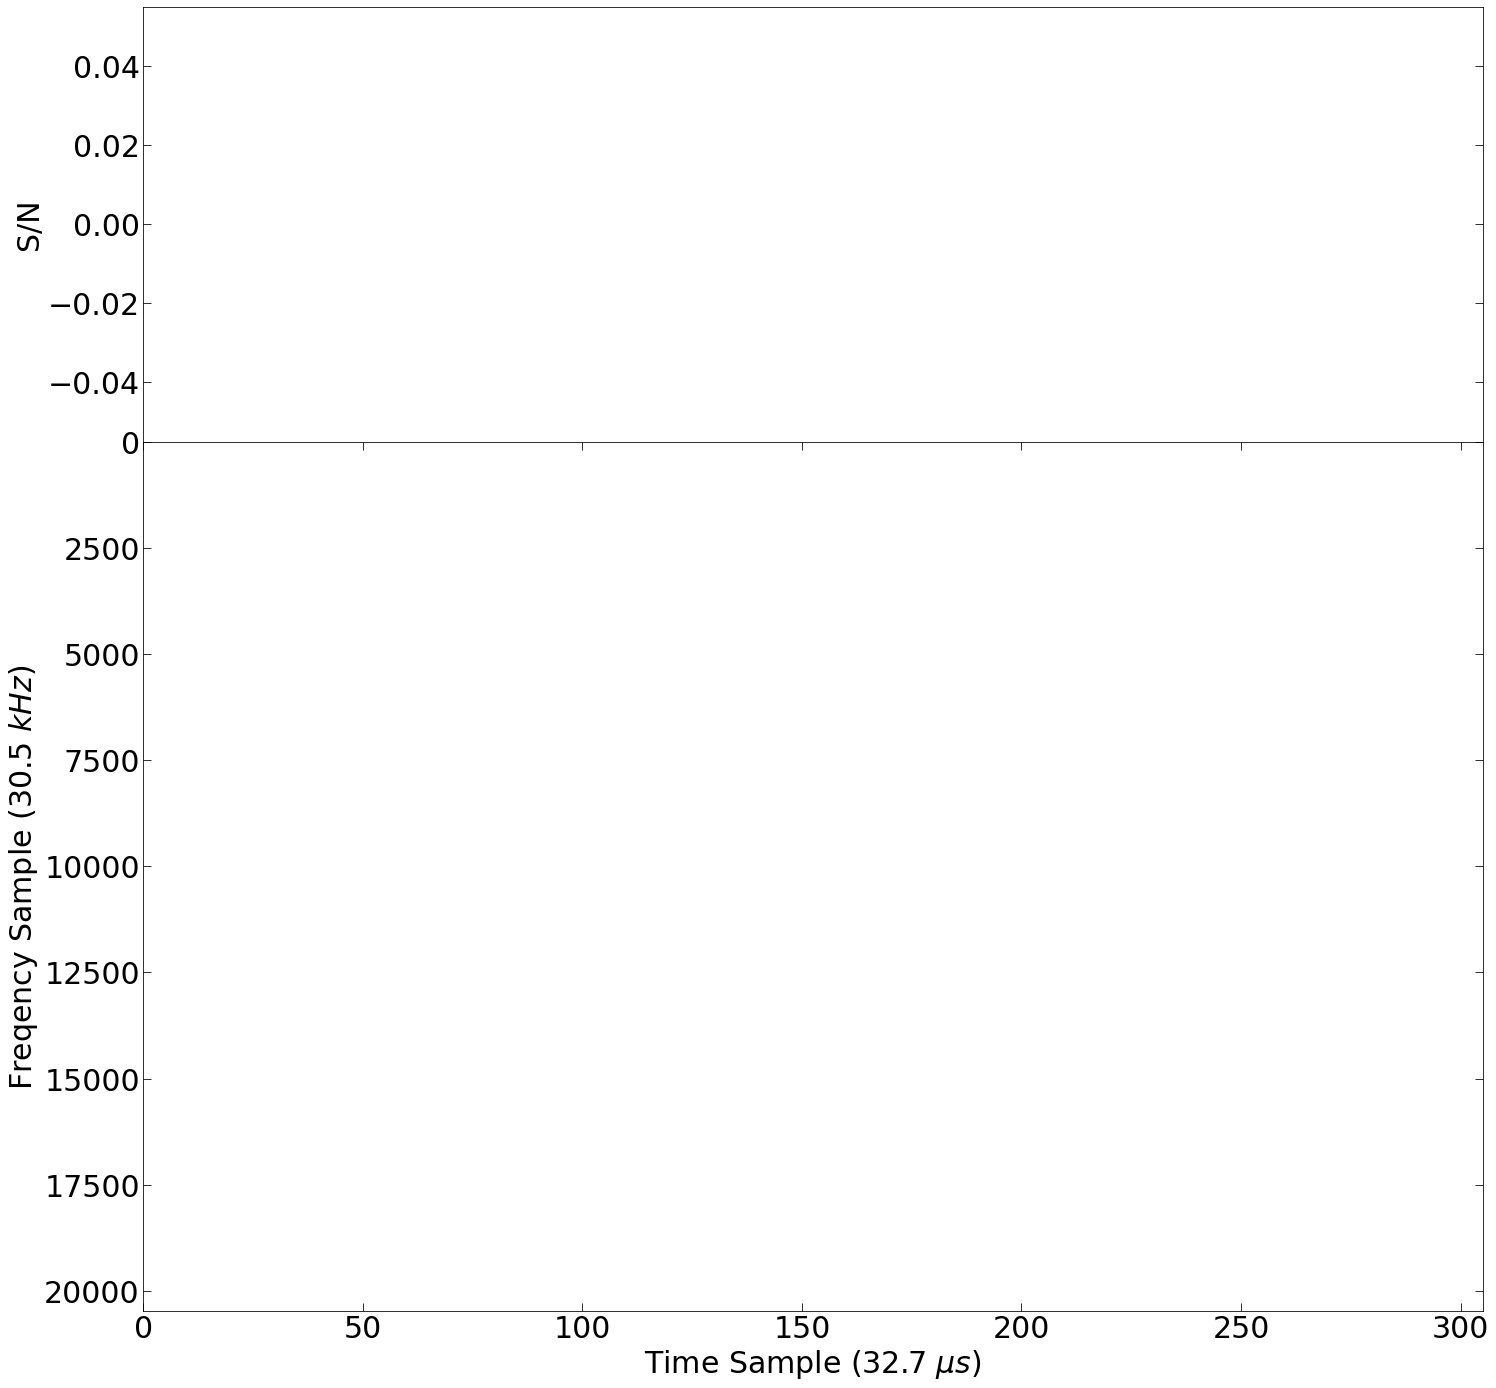

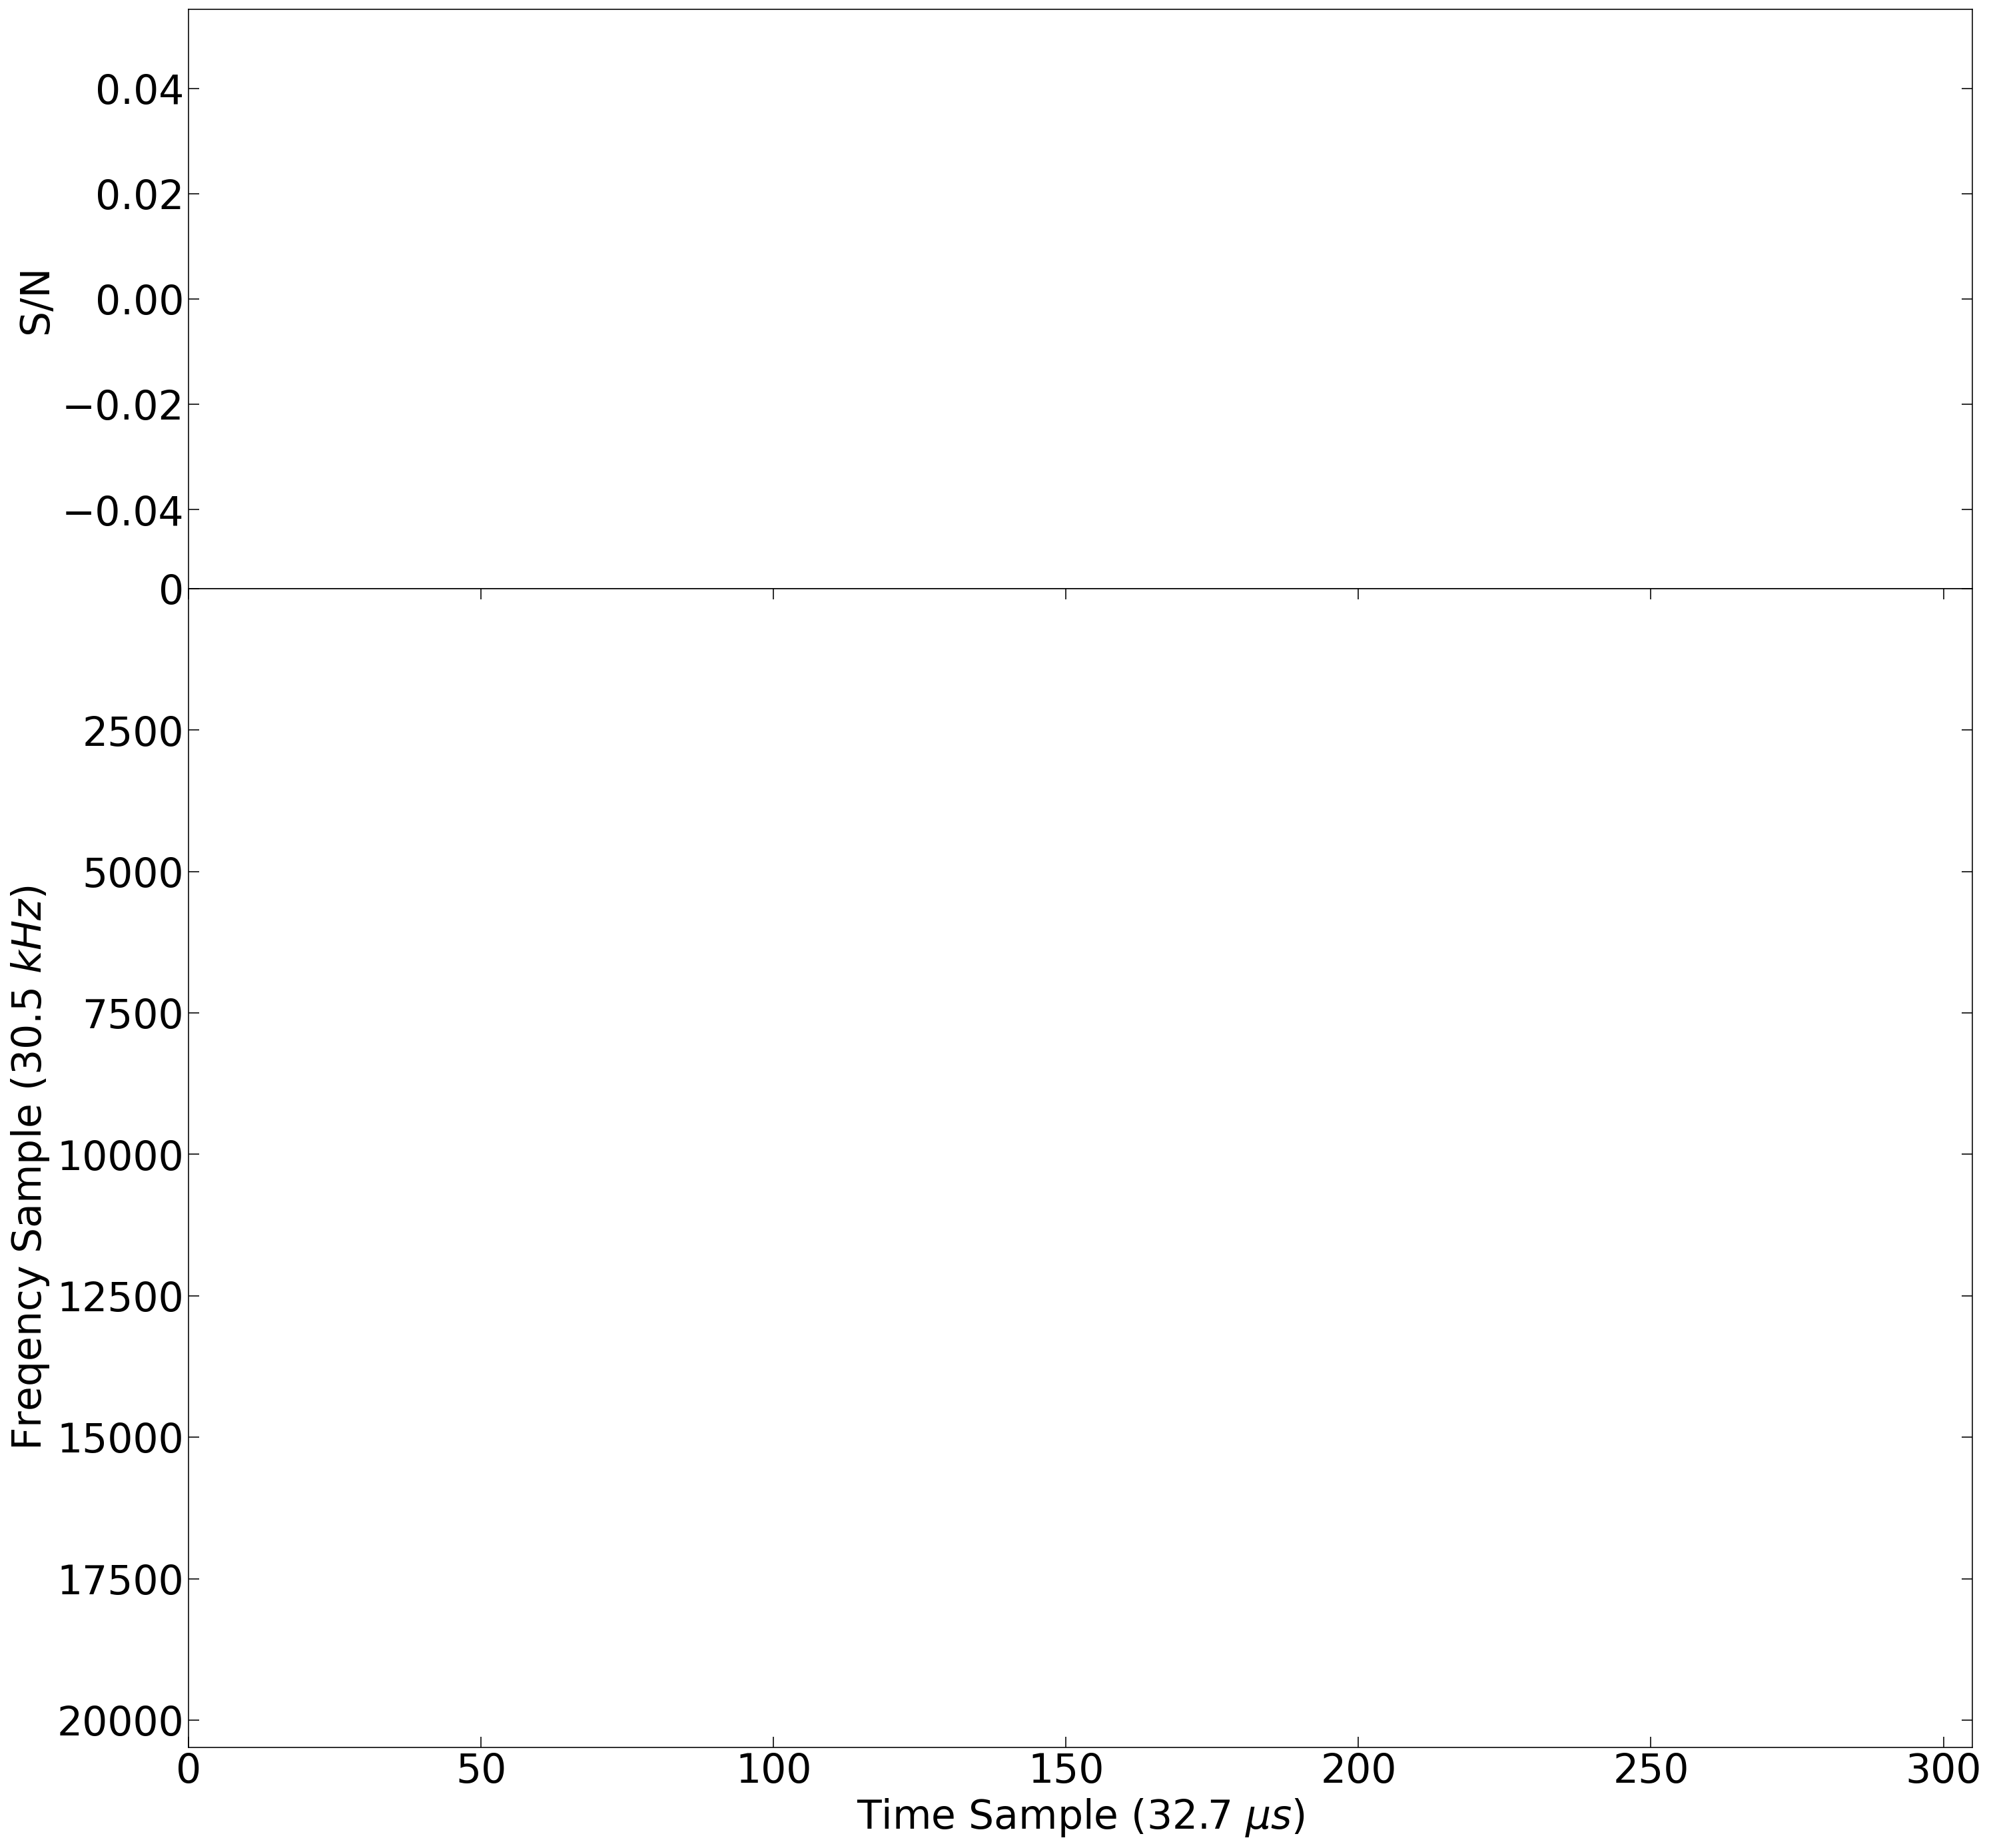

In [51]:
dashboard

Column
    [0] Row(background='#f0f0f0', margin=(10, 10, 10, 10))
        [0] Tabs(active=1, dynamic=True)
            [0] ParamFunction(function, lazy=True)
            [1] ParamFunction(function, lazy=True)
            [2] ParamFunction(function, lazy=True)
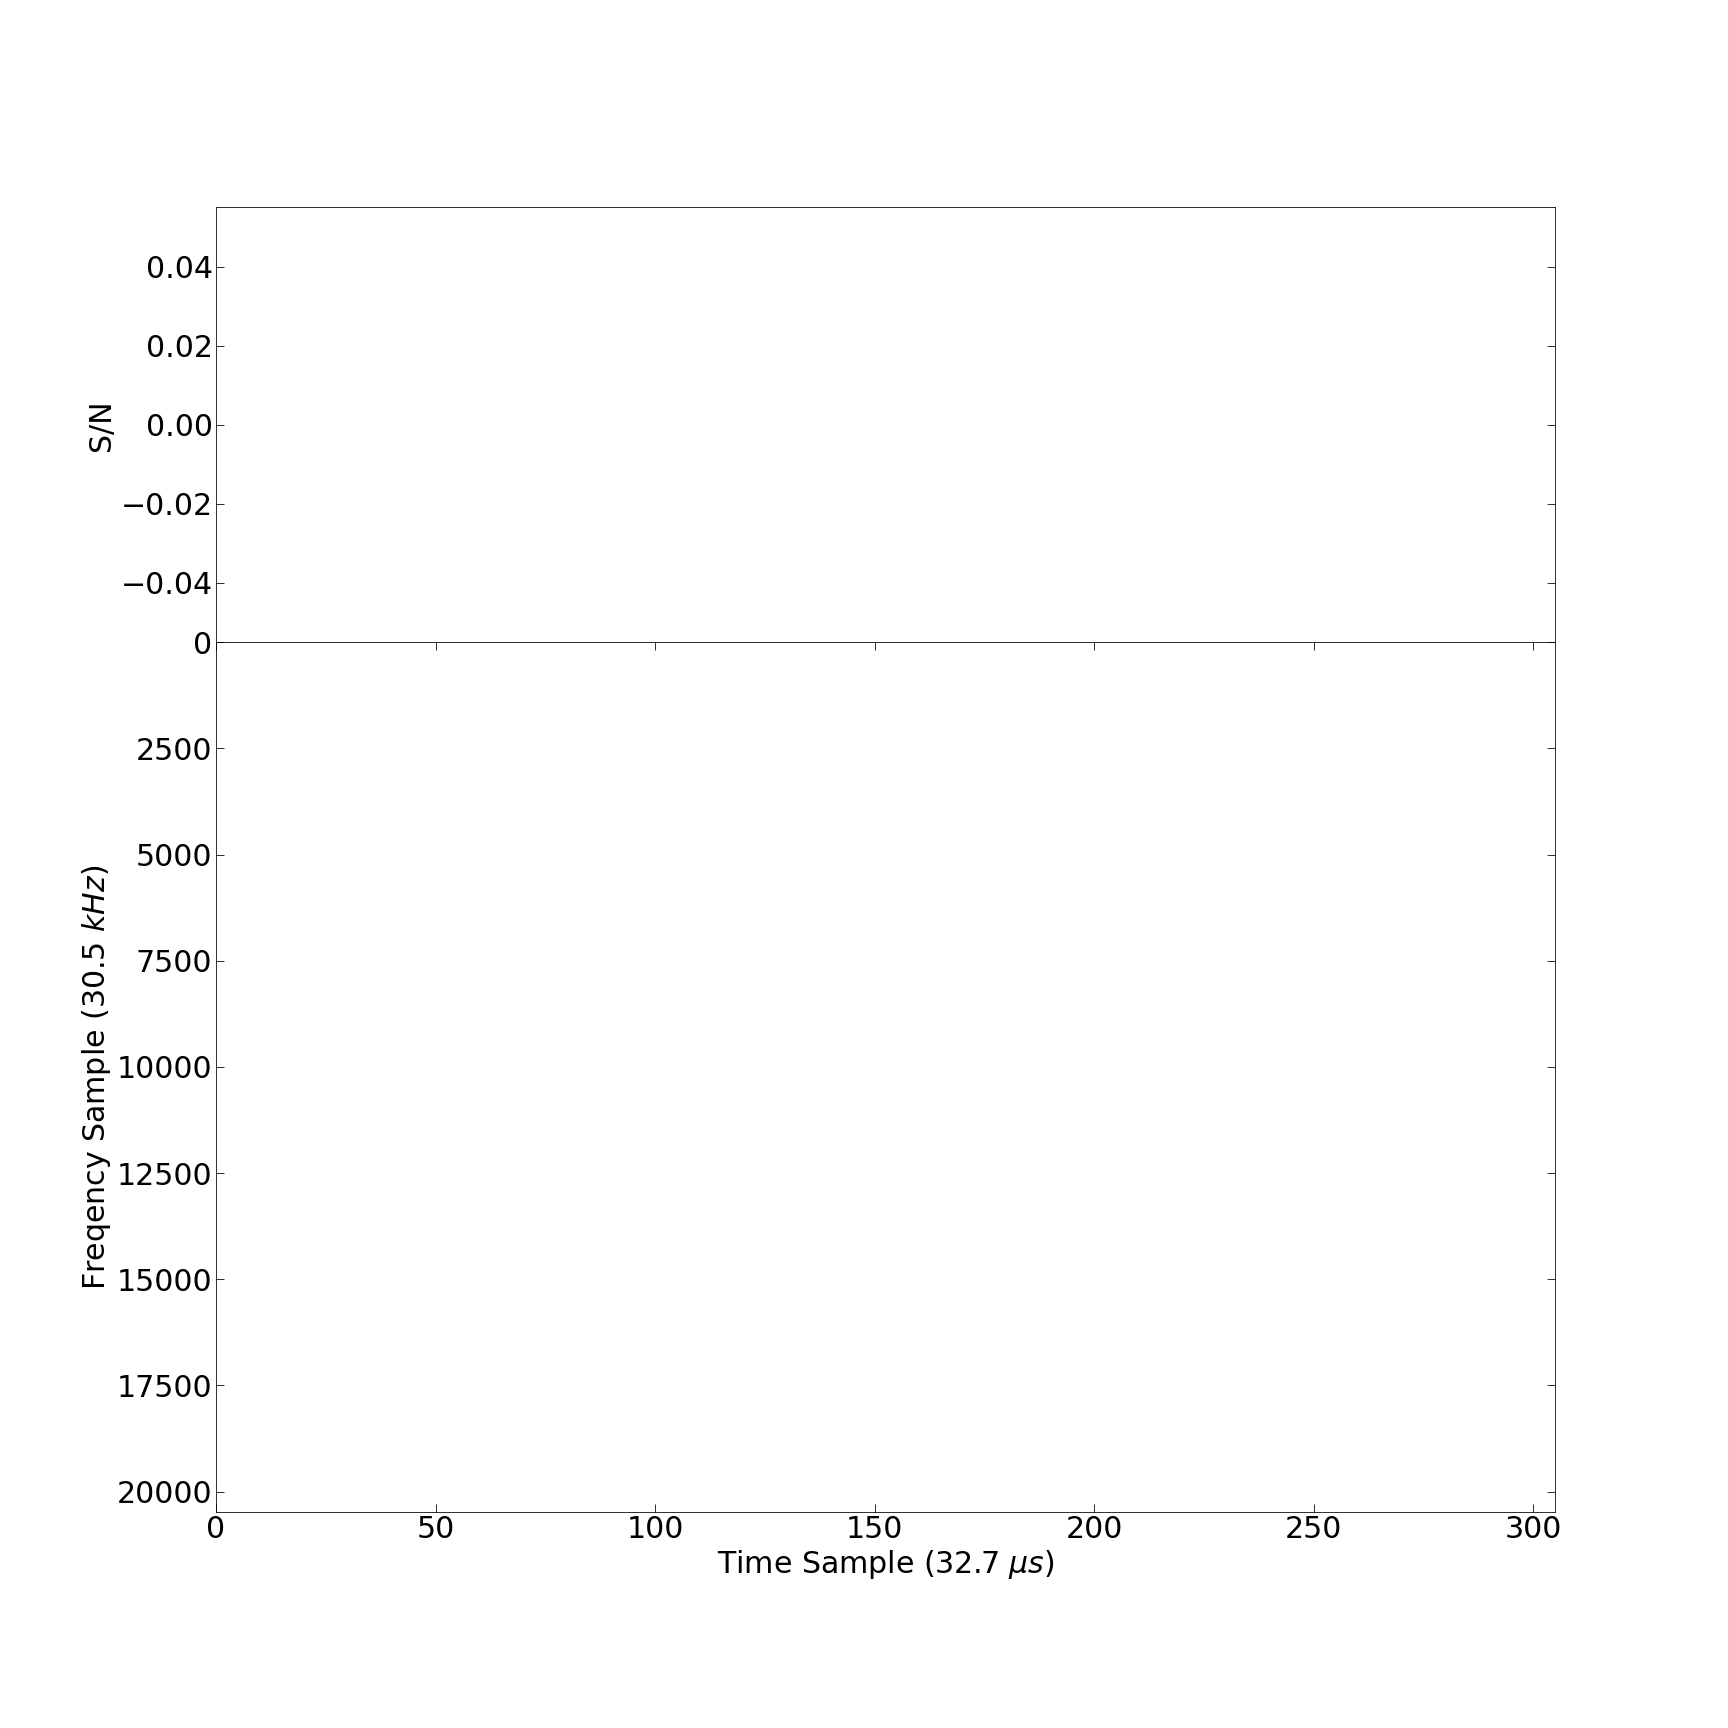

In [30]:
dashboard.servable(title="Burst Analysis Dashboard")